Here we perform a standard analysis on a immunohistochemistry image

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.util.montage import montage2d # for showing images slice by slice
montage2d_rgb = lambda im_stack, **kwargs: np.stack([montage2d(im_stack[:,:,:,i], **kwargs) 
                                                     for i in range(im_stack.shape[-1])],-1).astype(im_stack.dtype)
from skimage.data import immunohistochemistry as _ihc_image
ihc_image_rgb = _ihc_image()
ihc_image_gray = np.expand_dims(np.mean(ihc_image_rgb,-1)/255.0,-1)
x_dim, y_dim, n_channels = ihc_image_gray.shape

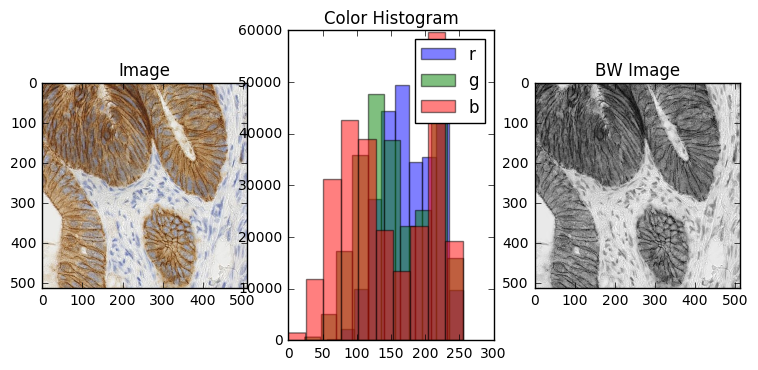

In [2]:
%matplotlib inline
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (9,4))
ax1.imshow(ihc_image_rgb)
ax1.set_title('Image')
for i, c in enumerate('rgb'):
    ax2.hist(ihc_image_rgb[:,:,i].ravel(), label=c, alpha = 0.5)
ax2.legend()
ax2.set_title('Color Histogram')
ax3.imshow(ihc_image_gray[:,:,0], cmap = 'gray')
ax3.set_title('BW Image')

# Multiple images
Let's now try to deal with multiple images


created ihc_set (25, 512, 512, 1)


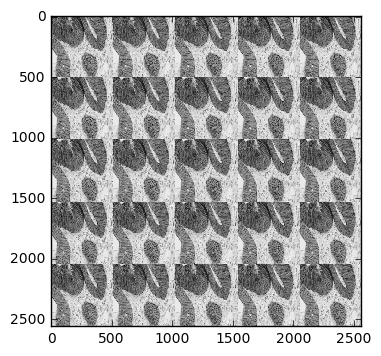

In [3]:
# create a stack of 9 images
img_count = 25
ihc_set = np.stack([ihc_image_gray]*img_count, 0)
print('created ihc_set', ihc_set.shape)
# show it as a montage
plt.imshow(montage2d(ihc_set[:,:,:,0]), cmap = 'gray')

# Task
We want to process, filter, enhance and analyze all of these images. To start we will use the simple task of performing a Gaussian filter. We can try the standard approach by using scikit-image in python

# skimage approach

In [4]:
# here we do a simple mean filter
from skimage.morphology import square
from scipy.ndimage import convolve
filt_kernel = square(60).astype(np.float32) # make the kernel for our filter
filt_kernel /= filt_kernel.sum()
apply_filter = lambda x: convolve(x, filt_kernel)

In [5]:
%%time
filt_image = apply_filter(ihc_image_gray[:,:,0])

Wall time: 2.39 s


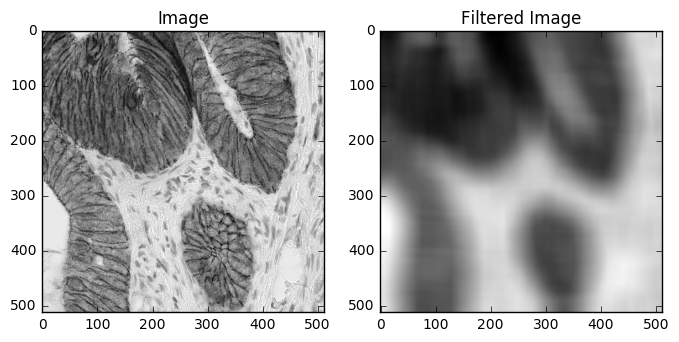

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8,4))
ax1.imshow(ihc_image_gray[:,:,0], cmap = 'gray')
ax1.set_title('Image')
ax2.imshow(filt_image[:,:], cmap = 'gray')
ax2.set_title('Filtered Image')

## Applying to the whole stack
Here we apply the operation to the whole stack (rather than just a single image). The simple python implementation does not urn this in parallel so it takes much longer to run

In [7]:
%%time
filt_set = np.stack([apply_filter(c_slice) for c_slice in ihc_set[:,:,:,0]],0)

Wall time: 54.9 s


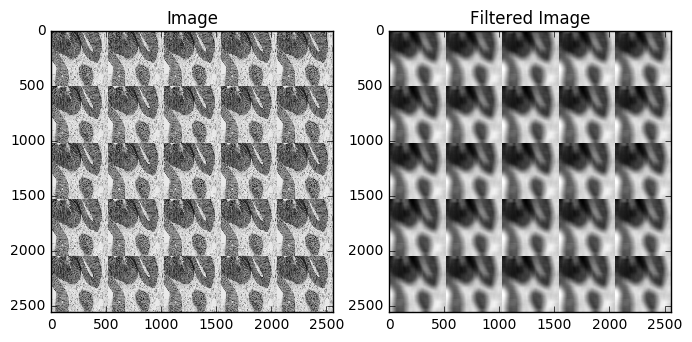

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8,4))
ax1.imshow(montage2d_rgb(ihc_set)[:,:,0], 'gray')
ax1.set_title('Image')
ax2.imshow(montage2d(filt_set), cmap = 'gray')
ax2.set_title('Filtered Image')

# Using Tensorflow
We can do the same task using tensorflow to take advantage of the GPU. It is a bit more complicated since we need to manually define what a Gaussian filter is and how the operations link together but the performance boost over python and skimage can be significant

In [9]:
import tensorflow as tf

In [36]:
# we first create a graph, this is the Directed Acyclical Graph where we keep all the operations we want to run
graph = tf.Graph()

Now we populate the graph to contain our computation, in this case just performing the single convolutional step. We have to use a placeholder for the input data so we can use our graph on different datasets (rather than hard-coding our data into the system)

In [37]:
with graph.as_default():
    # Input data.
    tf_input_data = tf.placeholder(
    tf.float32, shape=(ihc_set.shape[0], x_dim, y_dim, n_channels))
    # the kernel to use as the filter
    mean_filter_weights = tf.constant(np.expand_dims(np.expand_dims(filt_kernel,-1),-1), name = 'convolution_weights')
    # operation to perform
    filt_image = tf.nn.conv2d(tf_input_data, mean_filter_weights, [1, 1, 1, 1], padding = 'SAME', name = 'apply_filter')

In [12]:
%%time
with tf.Session(graph=graph) as sess:
    tf.global_variables_initializer().run(session = sess) # initialize all variables (here we dont have any but good practice)
    out_image = sess.run([filt_image], # the result to calculate
                            feed_dict={tf_input_data: ihc_set} # the input to give
                           )

Wall time: 36.1 s


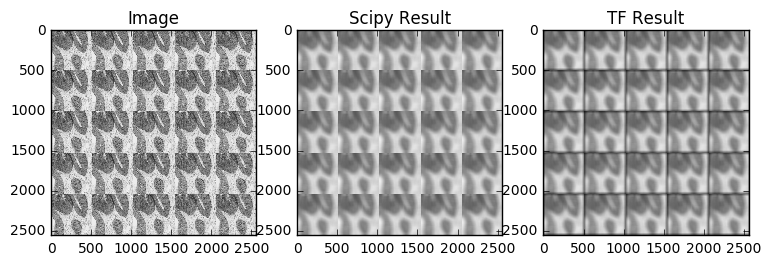

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (9,4))
ax1.imshow(montage2d(ihc_set[:,:,:,0]), cmap = 'gray', vmin =0, vmax = 1)
ax1.set_title('Image')
ax2.imshow(montage2d(filt_set), cmap = 'gray', vmin =0, vmax = 1)
ax2.set_title('Scipy Result')
ax3.imshow(montage2d(out_image[0][:,:,:,0]), cmap = 'gray', vmin =0, vmax = 1)
ax3.set_title('TF Result')

We see the performance goes from 53s on the CPU to 36s for the same operation on the GPU. We also see how easy it is to switch between CPU, GPU and even run code on multiple GPUs. We also see that the convolution operation can be defined in a number of different ways and the borders can be a real cause of headache when trying to compare results between implementations

In [40]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = ("<stripped %d bytes>"%size).encode('ascii')
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [41]:
show_graph(graph.as_graph_def())

# Moving Beyond
Where TensorFlow really shines is when performing many operations together. Rather than just doing one convolution here we perform an iterative convolution

In [42]:
# here we can make a bigger graph and compare
from time import time
def run_iter_conv(in_image, device = '/cpu:0', iterations = 5):
    with tf.device(device):
        bigger_graph = tf.Graph()
        with bigger_graph.as_default():
            # Input data.
            tf_input_data = tf.placeholder(
            tf.float32, shape=(in_image.shape[0], x_dim, y_dim, n_channels))
            # the kernel to use as the filter
            mean_filter_weights = tf.constant(np.expand_dims(np.expand_dims(filt_kernel,-1),-1), name = 'mean_filter_weights')
            # operation to perform 
            output_list = [tf_input_data]
            for i in range(iterations):
                output_list += [tf.nn.conv2d(output_list[-1], mean_filter_weights, [1, 1, 1, 1], padding = 'SAME', name = 'apply_filter_{}'.format(i))]
            final_output = output_list[-1]    
            
        
        with tf.Session(graph=bigger_graph) as sess:
            tf.global_variables_initializer().run(session = sess) # initialize all variables (here we dont have any but good practice)
            start_time = time()
            out_image = sess.run([final_output], # the result to calculate
                                feed_dict={tf_input_data: in_image} # the input to give
                               )
            return time()-start_time, bigger_graph

In [23]:
eval_timing = np.array([(iterations, 
  run_iter_conv(ihc_set[:4], device = '/cpu:0', iterations = iterations),
 run_iter_conv(ihc_set[:4], device = '/gpu:0', iterations = iterations))
 for iterations in range(1, 10, 2)])    

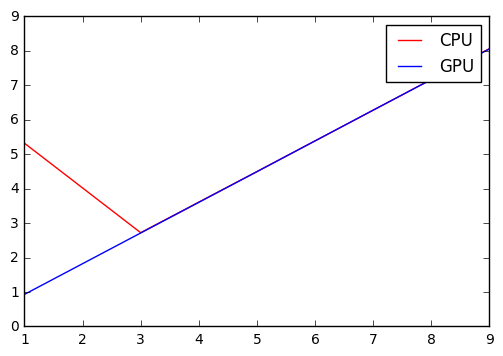

In [24]:
fig, ax1 = plt.subplots(1,1)
ax1.plot(eval_timing[:,0], eval_timing[:,1], 'r-', label = 'CPU')
ax1.plot(eval_timing[:,0], eval_timing[:,2], 'b-', label = 'GPU')
ax1.legend()

In [43]:
cpu_time, big_graph = run_iter_conv(ihc_set[:2], device = '/cpu:0', iterations = 20)
gpu_time, _ = run_iter_conv(ihc_set[:2], device = '/gpu:0', iterations = 20)
print('cpu_time', cpu_time)
print('gpu_time', gpu_time)

cpu_time 8.818389654159546
gpu_time 8.840866327285767


In [44]:
show_graph(big_graph.as_graph_def())